In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sea_ice_ds = xr.open_dataset('/home/mduplessis/data/era5/storms/combined_storms_sea_ice_cover.nc').load()

In [3]:
variable = 'sea_surface_temperature'

storms_ds = xr.open_dataset(f'/home/mduplessis/data/era5/storms/combined_storms_{variable}.nc').load()

In [4]:
# check the size comparison between the variable dataset and the sea ice dataset 

print(storms_ds.time.size)
print(sea_ice_ds.time.size)

578721
578721


In [5]:
if variable == 'winds':
    # Perform slicing once
    sliced_data = {
        "u10": storms_ds.u10[::2],
        "v10": storms_ds.v10[1::2],
        "pressure": storms_ds.pressure[::2],
        "time": storms_ds.time[::2],
        "storm_id": storms_ds.storm_id[::2]
    }

    # Create the xarray dataset
    ds_storm_wind = xr.Dataset(
        {
            "u10": (["time", "x", "y"], sliced_data["u10"].data),
            "v10": (["time", "x", "y"], sliced_data["v10"].data),
            "pressure": (["time"], sliced_data["pressure"].data),
            "storm_id": (["time"], sliced_data["storm_id"].data)
        },
        coords={
            "time": sliced_data["time"].data,
            "x": storms_ds.x.data,
            "y": storms_ds.y.data
        }
    )

    # Update the original dataset if needed
    storms_ds = ds_storm_wind

In [6]:
# check the size comparison between the variable dataset and the sea ice dataset after resizing

print(storms_ds.time.size)
print(sea_ice_ds.time.size)

578721
578721


In [ ]:
# if the size of the storms dataset does not match the sea ice, then resize it to match

if storms_ds.time.size != sea_ice_ds.time.size:
    storms_ds = storms_ds.isel(time=np.arange(sea_ice_ds.time.size))

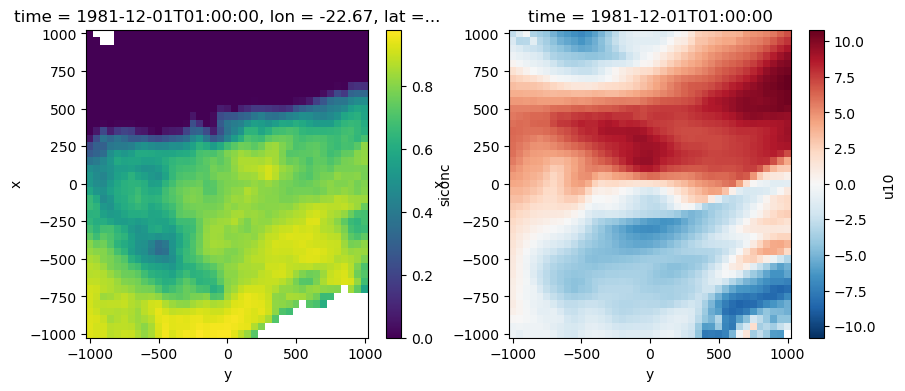

In [7]:
# test plot to see that it worked

fig,ax=plt.subplots(1,2,figsize=(10,4))

sea_ice_ds['siconc'].isel(time=0).plot(ax=ax[0])
storms_ds['u10'].isel(time=0).plot(ax=ax[1])

In [5]:
# whereever there is sea ice, make that value NaN

storms_seaice_no_ice = sea_ice_ds.siconc.where(sea_ice_ds.siconc == 0, np.nan)

In [6]:
storms_seaice_no_ice = storms_seaice_no_ice.where(storms_seaice_no_ice != 0, 1)

In [7]:
storms_ds['sst'] = storms_ds['sst'].where(storms_seaice_no_ice == 1, np.nan)

In [ ]:
storms_ds['u10'] = storms_ds['u10'].where(storms_seaice_no_ice == 1, np.nan)
storms_ds['v10'] = storms_ds['v10'].where(storms_seaice_no_ice == 1, np.nan)

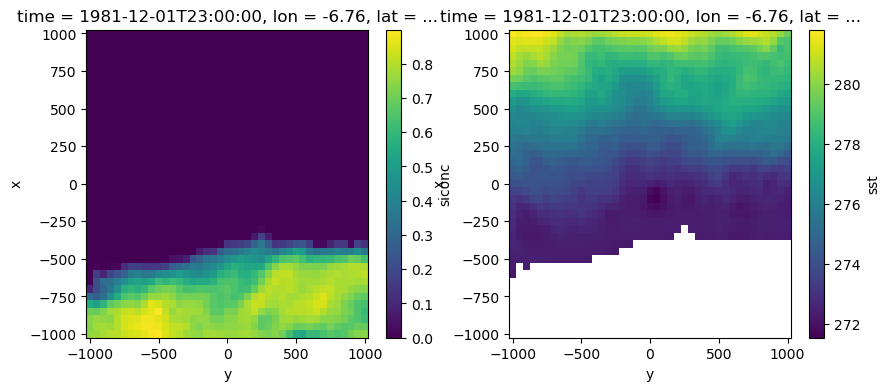

In [8]:
# test plot to see that it worked

fig,ax=plt.subplots(1,2,figsize=(10,4))

sea_ice_ds['siconc'].isel(time=200).plot(ax=ax[0])
storms_ds['sst'].isel(time=200).plot(ax=ax[1])

In [9]:
storms_ds.to_netcdf(f'/home/mduplessis/data/era5/storms/combined_storms_{variable}_no_ice.nc')